# EDA: интернет-магазин компьютерных игр

<font color="DarkCyan">Что тут есть: коэффициент корреляции Пирсона, диаграммы рассеяния, проверка гипотез о равенстве средних двух выборок (t-тест), выделение портретов пользователей

**Вводная:** интернет-магазин, который продаёт по всему миру компьютерные игры, запросил исследования о рынке игр. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
<br>
**Задача:** Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Старт работ и предобработка данных

**Подгрузим библиотеки, которые понадобятся нам в дальнейшем:**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

**Прогрузим датасет:**

In [2]:
df = pd.read_csv('games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Заменим имена столбцов:**

In [3]:
df.columns = df.columns.str.lower()

**проверим датасет на дубликаты:**

In [4]:
df['name'].duplicated().sum() #видим, что дубликаты по имени есть, посмотрим на них детально

5155

In [5]:
df[df['name'].duplicated()].sort_values(by='name').head(3) 
#видим, что имя дублирутся в случае выхода игры на разных платфомах или в разные годы

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.0,0.04,NaN,NaN,NaN
9507,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.0,0.01,65.0,tbd,T
4475,007: Quantum of Solace,PS2,2008.0,Action,0.17,0.00,0.0,0.26,NaN,NaN,NaN


In [6]:
df[df.duplicated()] #проверим, есть ли полные дубликаты строк, которые нужно обработать:

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


<b>Вывод по дубликатам: убедились, что полностью дублирующихся строк в датасете нет. </b></font><br>

**В инфо о датасете увидели пустоты в ряде столбцов. Взглянем на пропуски детально, оценим их кол-во и обработаем:**

In [7]:
df[df['name'].isnull()] # всего 2 пустых строки, уберем далее

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
print(df[df['year_of_release'].isnull()]['name'].nunique()) # 232 строки, уберём далее

232


In [9]:
df[df['genre'].isnull()] # те же 2 строки без названия игры + без жанра, уберем далее

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [11]:
df.groupby('rating').agg({'name': 'count'})

,name
rating,
AO,1
E,3990
E10+,1420
EC,8
K-A,3
M,1563
RP,3
T,2961


In [12]:
df[df['rating'].isnull()]['name'].count() #сколько строк без рейтинга?

6764

In [13]:
df['rating'] = df['rating'].fillna('no_ESRB') #заменим пустоты на значение no_ESRB (нет рейтинга ESRB)

In [14]:
df = df.dropna(subset=['name', 'year_of_release', 'genre']) # дропнули строки с пустотами
df.info() # проверили остаток non-null значений в инфо о датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


**Пропуски в столбцах critic_score, user_score оставили как есть**, тк заполнять их неким средним/медианным некорректно (это оценочные показатели), а удалять строки, где данные поля пусты - критично по объему (~60% датафрейма). Что касается причин незаполнения - можем сделать выводы, что данных нет в датафрейме по причине его некорректного формирования / человеческого фактора (спарсили не всё и не отовсюду).

**Разберемся со значением tbd в столбце оценок пользователей:**

In [15]:
df[df['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


In [16]:
#заменим на пустоты (tbd = to be determined)
df['user_score'] = df['user_score'].replace('tbd', np.nan)

**Корректно будет заменить 'tbd' на пропуск** - это нужно для дальнейшей корректной работы с данными столбца (как минимум для того, чтобы привести его к типу float и иметь возможность работать с цифрами).

**Преобразуем типы данных - уберем нули из годов релиза, сделаем столбцы с оценками дробными числами, а не объектами:**

In [17]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format = '%Y').dt.year
df['critic_score'] = df['critic_score'].astype(float)
df['user_score'] = df['user_score'].astype(float)

**Добавим столбец с суммарными продажами по всем регионам:**

In [18]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [19]:
df.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54


## Анализ данных

**Оценим общее кол-во выпускаемых игр в разрезе года релиза:**

In [20]:
p_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')

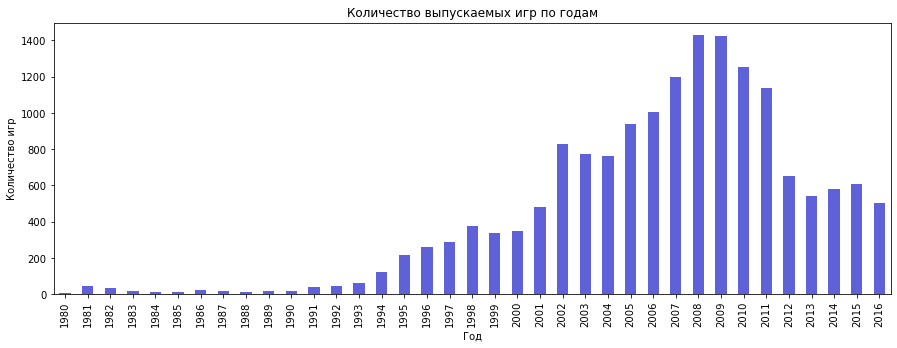

In [21]:
p_year.plot(kind='bar', figsize=(15,5), legend=False, color="#5f61d9");
plt.ylabel('Количество игр')
plt.xlabel('Год')
plt.title('Количество выпускаемых игр по годам');

In [22]:
df = df[df['year_of_release'] >= 2000]

*Достаточное кол-во релизов настигает нас ближе к нулевым. Для ответа на вопрос о LTV топ-платформ **оставляем в датасете данные с 2000 включительно.** Для дальнейшего анализа (после ответа на вопрос об LTV) возьмем меньший период.*

**Посмотрим, какие платформы лидировали за выбранный период. Оставим для анализа топ-12 (при выборе меньшего кол-ва не получится оценить сменеямость 1 версии платформы преемником):**

In [23]:
g_plat = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(12)
g_plat

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
XB       251.57
PC       205.72
GC       196.73
Name: total_sales, dtype: float64

**Сформируем отдельный датасет по топ-12. Раскидаем по нему сводную таблицу..**

In [24]:
df_t12 = df[df['platform'].isin(g_plat.index)]
p_df_t12 = df_t12.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
p_df_t12

platform,3DS,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,Wii,X360,XB
year_of_release,,,,,,,,,,,,
2000,NaN,NaN,0.07,NaN,4.66,39.17,NaN,NaN,NaN,NaN,NaN,0.99
2001,NaN,NaN,61.53,26.34,5.47,166.43,NaN,NaN,NaN,NaN,NaN,22.26
2002,NaN,NaN,74.16,51.81,8.57,205.38,NaN,NaN,NaN,NaN,NaN,48.01
2003,NaN,NaN,56.67,50.61,8.84,184.31,NaN,NaN,NaN,NaN,NaN,55.04
2004,NaN,17.27,77.91,28.82,10.39,211.81,NaN,NaN,7.06,NaN,NaN,65.42
2005,NaN,130.14,33.86,27.62,4.37,160.66,NaN,NaN,43.84,NaN,8.25,49.08
2006,NaN,119.81,5.28,11.26,2.85,103.42,20.96,NaN,55.32,137.15,51.62,10.04
2007,NaN,146.94,3.40,0.27,9.28,75.99,73.19,NaN,46.93,152.77,95.41,0.55
2008,NaN,145.31,NaN,NaN,12.42,53.90,118.52,NaN,34.55,171.32,135.26,0.18


**..и построим графики:**

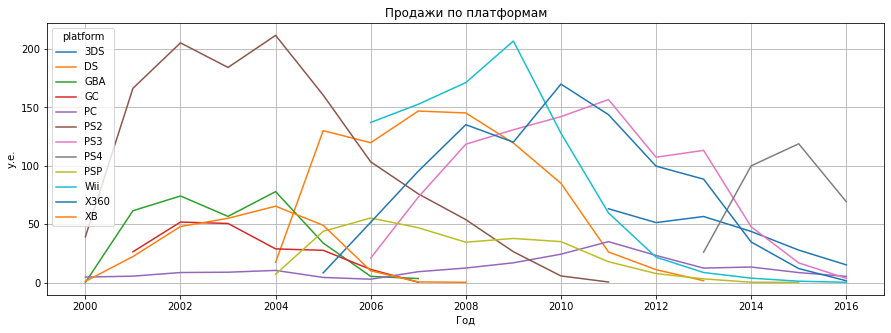

In [25]:
p_df_t12.plot(figsize=(15,5), grid=True)
plt.title('Продажи по платформам')
plt.xlabel('Год')
plt.ylabel('у.е.');

*Основные выводы по продолжительности жизни платформ:
<br>- большинство платформ **"живут" 8-10 лет**, в основном, сменяясь преемником
<br>- спад продаж часто происходит **на 5-6 год** существования платформы (часто это связано именно с выходом следующей платформы того же семейства)
<br> - к концу видимого нам периода (2016) **хорошие продажи (по сравнению с остальной выборкой топ-12) показывает PS4**. Семейство PlayStation было популярно и ранее (коричневая линия PS2 сияет в самом верху общего графика), поэтому преемник продолжает нести пальму первенства
<br>**- единственная платформа, показывающая некую стабильность - это PC**. Особенно хорошо это видно на графике - фиолетовая линия где-то на низах, зато во всю длину полотна. За период анализа у платформы были взлеты и падения - но на 2016 продажи PC находятся примерно на уровне 2000*
<br>
<br> **Более детально о сменяемости платформ:**
<br> **Nintendo DS:** *первая DS "прожила" ~9 лет (рыжая линия с 2004), продажи существенно упали на 5 году (2009), в 2011 выпустили Nintendo DS3
<br> **PlayStation:** продажи на PS2 (коричневая линия с пиком) существенно упали на 5 году жизни (2004), в 2006 вышла PS3. Продажи на PS3 (розовая линия с 2006) упали на 5 году жизни (2011), в 2013 вышла на PS4. Срок жизни PS2/PS3 - 10-12 лет до окончательного спада продаж и полной замены платформы преемником
<br> **Xbox:** первая XB "прожила" ~8 лет, получив падение на 5 году жизни (пик в 2004 и затем спад) - в 2005 был выпущен преемник  Xbox360. Xbox360 (синяя линия с 2005) потерял продажи в после 2010 (на 6 году жизни), преемник -  XOne - немного припозднился и вышел в 2013 (в таблице не приведена, тк нет в топ-12)*

**Для дальнейшего анализа будем брать данные с 2012 года включительно, тк при захватывании более ранних периодов данные не особо релевантны** (оч древняя инфо не поможет нам в прогнозе 2017 года)**, а при захвате меньшего периода данных останется очень мало.**
<br> прим.: в выборку возвращаются все платформы

In [26]:
df = df[df['year_of_release'] >= 2012]

**Раскидаем общие продажи в разрезе платформы / года из актуальной выборки в графиках. Сначала добавим колонку "семейства" платформы и посмотрим на графики в её разрезе:**

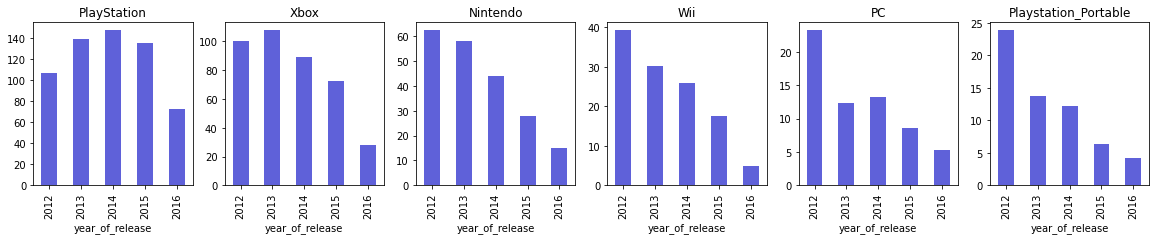

In [27]:
def family(plat): 
    if plat in ['X360', 'XOne']:
        return 'Xbox'
    elif plat in ['PS3', 'PS4', 'PS2']:
        return 'PlayStation'
    elif plat in ['Wii', 'WiiU']:
        return 'Wii'
    elif plat in ['PSP', 'PSV']:
        return 'Playstation_Portable'
    elif plat in ['DS', '3DS']:
        return 'Nintendo'
    else:
        return 'PC'

df['fam_plat'] = df['platform'].apply(family) #сделали колонку с категорией (семейство платформ) 

fig, axes = plt.subplots(1, len(df['fam_plat'].unique()), figsize=(20,3)) # сделали полотно с графиками в один ряд

for i, plat in enumerate(df['fam_plat'].unique()): # создали график для каждого семейства
    dfa = df[df['fam_plat'] == plat].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    dfa.plot(kind='bar', ax=axes[i], color="#5f61d9", title=plat, legend=False)
plt.show()

*На графиках видим, что большинство платформ имеет тренд на спад. Выделим 2 платформы:
<br>- **PlayStation**. Объемы продажи на платформе на порядок выше остальных. Прим.: в вводных данных было инфо, что данные по 2016 - не полные, так что нисходящий тренд на графике может быть и ошибочным наблюдением. Но даже и с ним PS находится в топе
<br>- **PC**. Вспомним общий график на предыдущем шаге - единственная стабильная платформа в своем роде*

**Посмотрим боксплоты:**

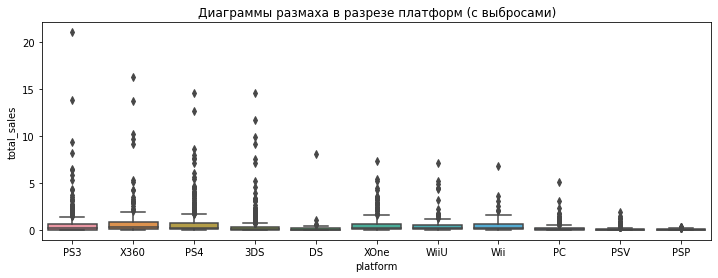

In [28]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='platform', y='total_sales');
plt.title('Диаграммы размаха в разрезе платформ (с выбросами)');

<b>Видим высокие точки (супер продажи единичных игр) по PS3, Xbox360, PS4, Nintendo 3DS. Посмотрим, как диаграммы будут выглядеть с лимитами: </b></font><br>

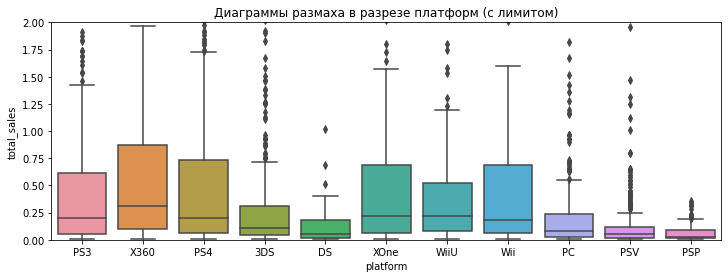

In [29]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x='platform', y='total_sales');
plt.title('Диаграммы размаха в разрезе платформ (с лимитом)');
plt.ylim(0,2);

In [30]:
g_plat_total = df.groupby('platform')['total_sales'].sum()
g_plat_total.sort_values(ascending=False)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

**- видим, что самые большие значения медиан у платформ Xbox, PS и Wii (медиана по всем платформам в каждом семействе примерно на одном уровне, на Xbox360 визуально выше всех)
    <br>- верхний (3-й) квартиль выше всех также у Xbox360
    <br>- рядышком с X360 диаграмма PS4 - которая по верхнему находится чуть ниже, но в то же имеет больше выбросов в верхней части. Проверили в группировке, у кого тотал-продаж больше за период - победила PS4. В целом, именно эта платформа является лидером (несмотря на визуальное превосходство X360), тк является актуальной на окончание периода (последняя в семействе, в отличие от X360, замененной XOne)**

## Анализ корреляции

**Посмотрим корреляцию между продажами и отзывами клиентов (возъмем топ-5 платформ по тотал-продажам):**

In [31]:
g_plat_total = g_plat_total.sort_values(ascending=False).head(5) #перезаписали ранее созданную табличку, оставив топ-5 по продажам
df_scores = df.dropna(subset=['user_score', 'critic_score']).query('platform in @g_plat_total.index')
# сделали маленький датафрейм, в котором есть отзывы юзеров, отзывы критиков, а платформы входят в топ-5 по продажам
print('platforms, top-5:' , list(df_scores['platform'].unique())) #посмотрели список платформ топ-5 из фрейма

platforms, top-5: ['PS3', 'X360', 'PS4', '3DS', 'XOne']


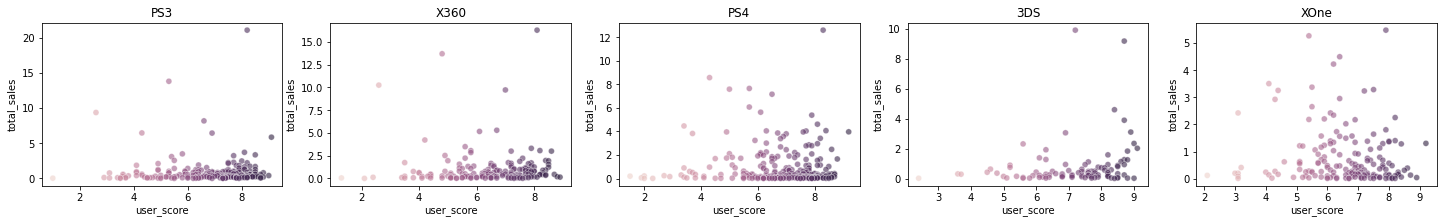

In [32]:
g_plat_total = g_plat_total.sort_values(ascending=False).head(5) 
#перезаписали ранее созданную табличку, оставив топ-5 по продажам
df_scores = df.dropna(subset=['user_score', 'critic_score']).query('platform in @g_plat_total.index')
#сделали маленький датафрейм, в котором есть отзывы юзеров, отзывы критиков, а платформы входят в топ-5 по продажам

fig, axes = plt.subplots(1, 5, figsize=(25,3)) #завели полотно по кол-ву платформ

for i, plat in enumerate(df_scores['platform'].unique()): #раскатываем диграммы рассеяния
    sctr = sns.scatterplot(data=df_scores[df_scores['platform'] == plat], x=df_scores['user_score'], 
                    y='total_sales', ax=axes[i], hue='user_score', legend=False, alpha=0.6) 
    sctr.set_title(plat)

<b> На графиках видим скорее отрицательную коррелляцию между оценками пользователей и объемом продаж (визуально кажется, что пользователи ставят высокие оценки играм с низкими продажами), но скорее всего игр с маленькими продажами просто больше. Для точности посмотрим коэфф-т Пирсона в разрезе топ-5 платформ: </b></font><br>

In [33]:
print('Корреляция оценок пользователей и объемов продаж')
for plat in df_scores['platform'].unique(): #пишем цикл, который соберет коэф-ты пирсона и кол-во строк в выборке
    counter = 0
    us_sal = df_scores[df_scores['platform'] == plat]['user_score'].corr(df_scores[df_scores['platform'] == plat]['total_sales'])
    counter += len(df_scores[df_scores['platform'] == plat])
    print(plat, '/', round(us_sal,4), '/', counter)

Корреляция оценок пользователей и объемов продаж
PS3 / 0.0032 / 213
X360 / -0.002 / 171
PS4 / -0.0336 / 249
3DS / 0.2018 / 100
XOne / -0.094 / 165


<b> По коэф-ту Пирсона видим почти полное отсутствие корреляции между оценками пользователя и объемом продаж (слабая положительная корреляция есть по 3DS). Делаем вывод, что показатели объема продаж/отзывов пользователей слабо связаны по топ-5 платформ (пользователи часто ставят хорошие оценки играм с низкими продажами, также пользователи могут не ориентироваться на другие отзывы при покупке и формировать свое личное мнение уже после покупки игры, также о вкусах не спорят - оценки отдельных людей могут быть очень разными, в отличие от оценок критиков, часто звучащих +- в унисон). 
    <br> ----
    <br> Посмотрим в диаграммах рассеяния  / коэфф-х Пирсона связь оценок критиков и объемов продаж:
    </b></font><br>

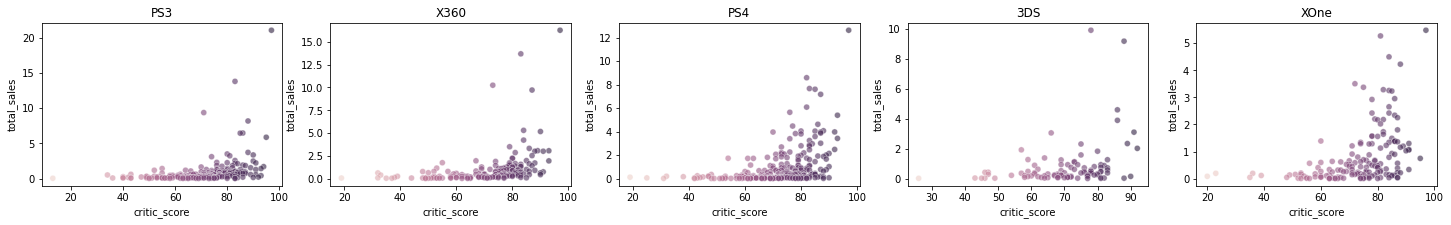

In [34]:
#и такое же полотно диаграмм продаж с оценками критиков
fig, axes = plt.subplots(1, 5, figsize=(25,3)) #завели полотно по кол-ву платформ

for i, plat in enumerate(df_scores['platform'].unique()): #раскатываем диграммы рассеяния
    sctr = sns.scatterplot(data=df_scores[df_scores['platform'] == plat], x=df_scores['critic_score'], 
                    y='total_sales', ax=axes[i], hue='critic_score', legend=False, alpha=0.6) 
    sctr.set_title(plat)

In [35]:
print('Корреляция оценок критиков и объемов продаж')
for plat in df_scores['platform'].unique(): 
    counter = 0
    us_sal = df_scores[df_scores['platform'] == plat]['critic_score'].corr(df_scores[df_scores['platform'] == plat]['total_sales'])
    counter += len(df_scores[df_scores['platform'] == plat])
    print(plat, '/', round(us_sal,4), '/', counter)

Корреляция оценок критиков и объемов продаж
PS3 / 0.3311 / 213
X360 / 0.3606 / 171
PS4 / 0.4059 / 249
3DS / 0.3106 / 100
XOne / 0.4104 / 165


<b> Совсем другая картина - все платформы показывают среднюю положительную корреляцию оценок критиков и обьъемов продаж. Почему так? Причина тому в том, что критики действительно влияют на продажи игр, тк их оценки часто публикуются аккурат с релизом игры (или незадолго после). Т.е. хорошая оценка игры критиками часто может создать предвзятую симпатию у пользователей, которые, в свою очередь, обеспечат продажи. И наоборот.
    <br> Сильнее всего прямая связь оценок критиков / продаж заметна на платформах PS4 / XOne.
    </b></font><br>
<br>Ниже справочно - интерпретация коэффициентов корреляции

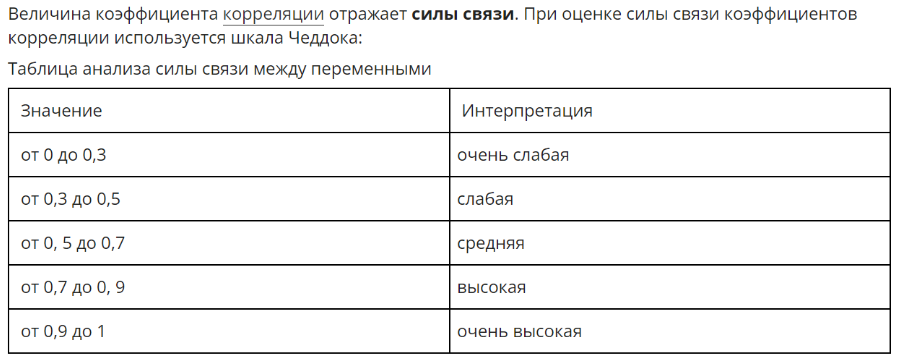

**Раскатаем полный свод по суммам продаж / кол-ву игр в разрезе жанра:**

In [36]:
p_genre = df.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'sum', 'mean', 'median', 'max'])
p_genre.columns = ['number_of_games', 'total_sales', 'mean_sales', 'median_sales','max_sale']
p_genre.sort_values(by='total_sales', ascending=False)

,number_of_games,total_sales,mean_sales,median_sales,max_sale
genre,,,,,
Action,1031,441.12,0.427856,0.120,21.05
Shooter,235,304.73,1.296723,0.440,14.63
Role-Playing,370,192.80,0.521081,0.140,14.60
Sports,268,181.07,0.675634,0.240,8.58
Misc,192,85.04,0.442917,0.120,9.18
Platform,85,61.00,0.717647,0.210,9.90
Racing,115,53.50,0.465217,0.140,7.09
Fighting,109,44.49,0.408165,0.130,7.55
Simulation,80,35.12,0.439000,0.120,9.17


**Посмотрим в боксплотах:**

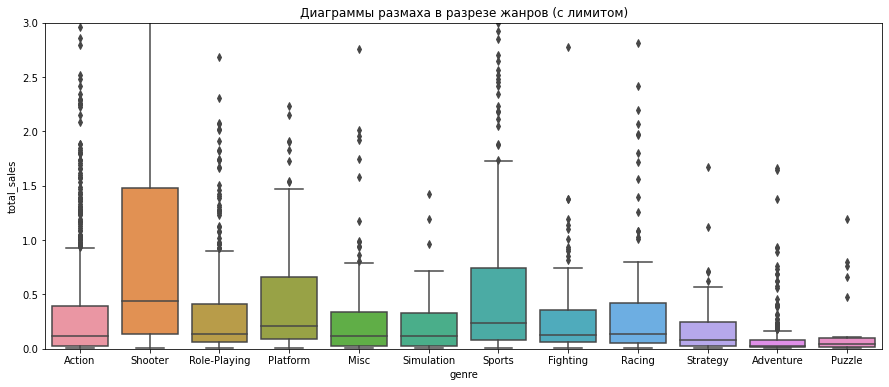

In [37]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df, x='genre', y='total_sales');
plt.title('Диаграммы размаха в разрезе жанров (с лимитом)');
plt.ylim(0,3);

<b> Вывод:
<br>- топ-3: экшн, шутеры и спорт
    <br>- экшн лидирует по 2 причинам - больше всего игр (видно в своде), много выбросов за пределами ящика (видно на диаграмме, это крупные продажи с большими чеками)
    <br>- шутер на 2 месте по причине медианы самого крупного размера (медиана = 0.440, для сравнения - у экшна медиана в 4 раза меньше) + высокого "среднего чека" 1 игры (1.29, для сравнения - у экшна среднее в 3 раза меньше). В то же время кол-во шутеров почти в 4 раза меньше набора экшна.
    <br>**Самый прибыльный жанр (экшн) за период анализа принес примерно в 30 раз больше денег, чем самый непопулярный (паззл).** Экшн охватывает целевой сегмент гейм-индустрии, на который есть постоянный спрос
    </b></font><br>

## Портрет пользователя по региону

<b> Посмотрим, какие платформы популярнее всего в регионе: </b></font><br>

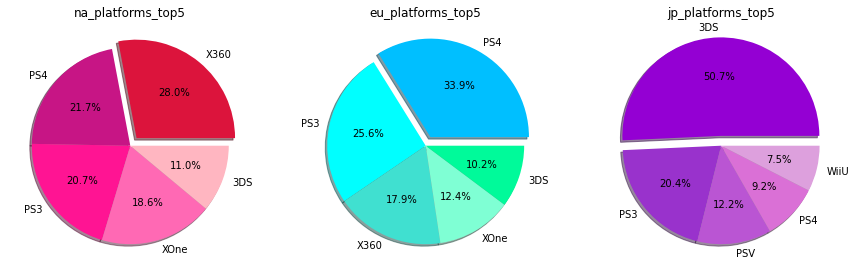

In [38]:
g_plat_na = df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
g_plat_eu = df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
g_plat_jp = df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].set_title('na_platforms_top5');
axes[1].set_title('eu_platforms_top5');
axes[2].set_title('jp_platforms_top5');
explode = (0.1, 0.00, 0.00, 0.00, 0.00)
palette_na = ("#DC143C", "#C71585", "#FF1493", "#FF69B4", "#FFB6C1")
palette_eu = ("#00BFFF", "#00FFFF", "#40E0D0", "#7FFFD4", "#00FA9A")
palette_jp = ("#9400D3", "#9932CC", "#BA55D3", "#DA70D6", "#DDA0DD")
axes[0].pie(g_plat_na, explode=explode, labels=g_plat_na.index, colors=palette_na, autopct='%1.1f%%', shadow=True);
axes[1].pie(g_plat_eu, explode=explode, labels=g_plat_eu.index, colors=palette_eu, autopct='%1.1f%%', shadow=True);
axes[2].pie(g_plat_jp, explode=explode, labels=g_plat_jp.index, colors=palette_jp, autopct='%1.1f%%', shadow=True);

<b>В каждом регионе - свои лидеры:
<br>-**США: платформа Xbox360**, в сравнительно небольшом отрыве находится PS4/PS3;
<br>-**ЕС: платформа PS4, следующая по популярности -  PS3. Семейство Xbox занимает существенно меньшую долю рынка;
<br>-**Япония: "домашний" регион" **Nintendo** и PlayStation, притом 3DS идет в серьзном отрыве от PS3. Остальные в топ-5 также местные (PS Vita, PS4, WiiU)
    </b></font><br>

**Построим диаграммы по жанрам:**

In [39]:
p_genre = p_genre.sort_values(by='total_sales', ascending=False).head(5)
# перезаписали ранее созданную табличку, оставив топ-5

def cat_genre(genre): #сделали формулу, возвращающую жанр из топ-5 или значение Other_genre, если жанр там не находится
    if genre in p_genre.index:
        return genre
    else:
        return 'Other_genre'

df['cat_genre'] = df['genre'].apply(cat_genre)

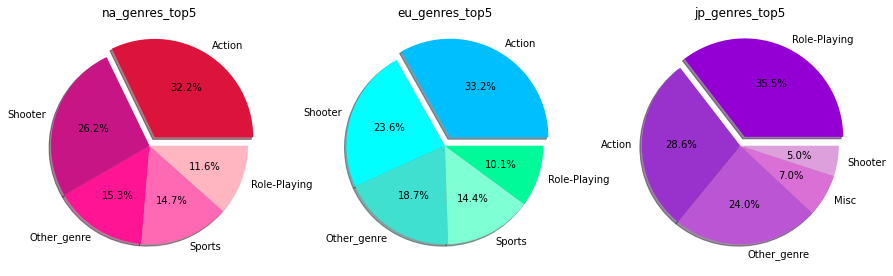

In [40]:
g_genre_na = df.groupby('cat_genre')['na_sales'].sum().sort_values(ascending=False).head(5) #заменили тело группировки
g_genre_eu = df.groupby('cat_genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
g_genre_jp = df.groupby('cat_genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].set_title('na_genres_top5');
axes[1].set_title('eu_genres_top5');
axes[2].set_title('jp_genres_top5');
explode = (0.1, 0.00, 0.00, 0.00, 0.00)
palette_na = ("#DC143C", "#C71585", "#FF1493", "#FF69B4", "#FFB6C1")
palette_eu = ("#00BFFF", "#00FFFF", "#40E0D0", "#7FFFD4", "#00FA9A")
palette_jp = ("#9400D3", "#9932CC", "#BA55D3", "#DA70D6", "#DDA0DD")
axes[0].pie(g_genre_na, explode=explode, labels=g_genre_na.index, colors=palette_na, autopct='%1.1f%%', shadow=True);
axes[1].pie(g_genre_eu, explode=explode, labels=g_genre_eu.index, colors=palette_eu, autopct='%1.1f%%', shadow=True);
axes[2].pie(g_genre_jp, explode=explode, labels=g_genre_jp.index, colors=palette_jp, autopct='%1.1f%%', shadow=True);

<b> 
    <br>- США / ЕС - рынок ведет себя очень похоже, примерно одинаковые доли между экшном и шутерами, на 3 место вышла категория "other_genre" (другие), отдельные крупные доли забрали спорт-игры и RPG
    <br>- в Японии на 1 месте - RPG, далее с отрывом идет экшн, на 3 месте - другие жанры. Шутеры и misc (miscellaneous = "разное") также получили отдельные доли в топ-5 (5-7%). Другая компановка жанров связана с тем, что Япония имеет тенденции, отличные от западных + страна сосредоточена на развитии локальных продуктов (к примеру, самая популярная игра в датасете - "Покемоны" - супер-популярная медиафраншиза, которую можно назвать частью современной японской культуры)
    </b></font><br>

**Влияет ли рейтинг ESRB на продажи в отдельном регионе? Построим диаграммы по среднему значению продаж в разрезе рейтинга:**

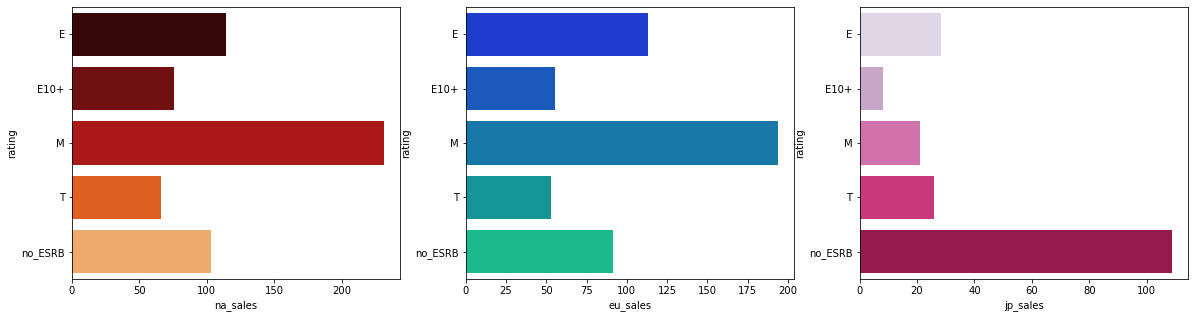

In [41]:
p_rate = df.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
fig, axes = plt.subplots(1,3, figsize=(20,5))

sns.barplot(x=p_rate['na_sales'], y=p_rate.index, ax=axes[0], palette='gist_heat')
sns.barplot(x=p_rate['eu_sales'], y=p_rate.index, ax=axes[1], palette='winter')
sns.barplot(x=p_rate['jp_sales'], y=p_rate.index, ax=axes[2], palette='PuRd')
plt.show()

**ESRB - система рейтинга, которая используется в США/Канаде и (частично) в ЕС. Видим, что в Японии больше всего продаж в баре no_ESRB (без рейтинга, тк по видимому он не применяется к играм вне западного рынка). Посмотрим на продажи в разрезе рейтинга / региона в своде:**

In [42]:
df['rating'] = df['rating'].replace('T', 'Teen') #расширим аббревиатуры до их значений, чтоб понимать, кто есть кто
df['rating'] = df['rating'].replace('E', 'Everyone')
df['rating'] = df['rating'].replace('E10+', 'Everyone 10 and older')
df['rating'] = df['rating'].replace('M', 'Mature')
df['rating'] = df['rating'].replace('RP', 'Rating Pending')
df['rating'] = df['rating'].replace('EC', 'Early Childhood')
#пересоздадим сводную, чтоб она подцепила новые названия
p_rate = df.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], 
                        aggfunc=['sum'])
p_rate.columns = ['sum_eu', 'sum_jp', 'sum_na']
p_rate

,sum_eu,sum_jp,sum_na
rating,,,
Everyone,113.03,28.33,114.37
Everyone 10 and older,55.37,8.19,75.70
Mature,193.96,21.20,231.57
Teen,52.96,26.02,66.02
no_ESRB,91.50,108.84,103.31


*Итого по влиянию рейтинга ESRB на продажи в различных регионах:
<br>**- сама система родом из США - в США / ЕС и используется в большей степени**. Продажи (с нормальным весом) есть почти во всех категориях рейтинга
<br>**- в США / ЕС суммарный объем продаж соответствует виду рейтинга**. Наибольший объем - в играх рейтинга Mature (что характерно). Игр для малышей мало - вот и продаж в этом рейтинге очень маленькое кол-во и только в США
<br>**-Япония имеет закрытый рынок гейминга и не котирует западные рейтинги**. Некоторое кол-во продаж есть в разных категориях, но наибольший объем продаж сосредоточен в рейтинге RP (неприсвоенном). Памятуя о том, что мы сами заменили пропуски в столбце на значение no_ESRB мы можем сделать также вывод о том, что японские игры просто не отправляются на "оцифровку" системой ESRB*

## Проверка гипотез

<b>Проверим гипотезу о равенстве средних значений двух независимых выборок с помощью t-теста.

**#Н0 (нулевая гипотеза)** - средние пользовательские рейтинги игр на платформах XOne и PC одинаковые
<br>**#Н1 (альтернативная гипотеза)** - средние пользовательские рейтинги игр на платформах XOne и PC отличаются друг от друга

In [47]:
score_x = df.query('platform == "XOne"')['user_score'].dropna() 
score_pc = df.query('platform == "PC"')['user_score'].dropna()
alpha = 0.01 #проверяем прям "одинаковость", поэтому ставим строгое значение стат.значимости

results = st.ttest_ind(score_x, score_pc, equal_var=False) #применим метод проверки гипотезы о рав-ве средних 2 выборок 
print('p_значение, гипотеза 1 (платформы):', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_значение, гипотеза 1 (платформы): 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**#Н0 (нулевая гипотеза)** - средние пользовательские рейтинги жанров Action и Sports одинаковые<br>
**#Н1 (альтернативная гипотеза)** - средние пользовательские рейтинги жанров Action и Sports отличаются друг от друга

In [46]:
score_action = df.query('genre == "Action"')['user_score'].dropna() 
score_sports = df.query('genre == "Sports"')['user_score'].dropna()
alpha = 0.05 #здесь уменьшим строгость показателя - чтобы "одинаковость" данных не смогла ускользнуть от нас

results = st.ttest_ind(score_action, score_sports, equal_var=False)
print('p_значение, гипотеза 2 (жанры):', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_значение, гипотеза 2 (жанры): 4.24307776572644e-20
Отвергаем нулевую гипотезу


In [44]:
print('средняя оценка игр на XOne', round(df.query('platform == "XOne"')['user_score'].mean(),3))
print('средняя оценка игр на PC', round(df.query('platform == "PC"')['user_score'].mean(), 3))
print('----------------------------')
print('средняя оценка экшн-игр', round(df.query('genre == "Action"')['user_score'].mean(),3))
print('средняя оценка спорт-игр', round(df.query('genre == "Sports"')['user_score'].mean(),3))

средняя оценка игр на XOne 6.521
средняя оценка игр на PC 6.429
----------------------------
средняя оценка экшн-игр 6.825
средняя оценка спорт-игр 5.456


*В обоих случаях мы использовали t-тест для проверки гипотезы о равенстве среднего двух независимых выборок. Соответственно:
<br>- нулевая гипотеза в обоих случаях звучала, как "средние двух выборок - равны"
<br>- альтернативная, в свою очередь, звучала, как "средние двух выборок отличны друг от друга" (2х-сторонний тест, поэтому - в какую сторону они отличаются - неважно, важен лишь факт отличия)
<br>- в 1 гипотезе поставили уровень стат.значимости = 0.01 (строгий), тк проверяем именно равенство средних, и нужно более точное подтверждение "одинаковости" средних
<br>- во 2 гипотезе выбрали уровень стат.значимости = 0.05 (помягче), чтобы возможная "одинаковость" средних точно не ускользнула от нас. Заметка: в случае установки уровня в размере 0.01 нулевая гипотеза о равенстве также отвергнется, тк получили крохотный p_value (минус 15 степень)
<br>
<br>Также у нас есть возможность посмотреть "вживую" на средние показатели выборок. Итого имеем:
<br>**- средние пользовательские рейтинги платформ XOne / PC примерно равны** (не получилось отвегнуть гипотезу об их равенстве)
<br>**- средние пользовательские рейтинги игр в жанрах "экшн" и "спорт" не равны** (отвергнули гипотезу об их равенстве). Количественно экшн-игры имеют более высокую среднюю оценку по сравнению с играми жанра "спорт".*

## Выводы исследования

**Мы посмотрели множество разрезов, преследуя цель выявить закономерности, определяющие успешность игры. Это позволит нам сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Что мы имеем в итоге:
<br>
<br>1|  ПЛАТФОРМЫ**
<br>- самой перспективной платформой (на конец 2016 года) можно считать PlayStation 4: сохраняются большие объемы продаж (по сравнению с другими игроками рынка), отличная история, широкая дистрибуция (завоевали как локальный рынок, так и западный)
<br>- также перспективной платформой можно назвать PC: за свою стабильность длинною во всю историю гейминга, а также за особую позицию (все же ПК-гейминга всегда шел и будет идти особняком от консолей)
<br><br>
**2| ОЦЕНКИ**
<br>- оценки пользователей не влияют /слабо влияют на объем продаж (смотрели разрез по 5 платформам с топ-продажами)
<br>- оценки критиков напрямую влияют на объем продаж (тот же разрез) - чем выше оценка критиков, тем больше продажи
</font><font color='Blue'><b>  </b></font><br>
<br>**3| ЖАНРЫ**
<br>- в охвате всех регионов топ-3 жанров держат за собой экшн, шутеры и спорт-игры
<br>- "отрицательный" топ-3 (с конца) занимают паззлы, стратегии и приключения
<br><br>
**4| РЫНКИ**
<br>- рынки США и Европы во многом схожи, рынок Японии играет по своим правилам
<br>- по жанрам наибольшие продажи в США/ЕС имеют все те же экшн, шутеры и "другие" (жанры, не вошедшие в топ-5 самых популярных). Также отдельные крупные доли рынка занимают игры жанра "спорт" и RPG. 
    <br>- cовсем другой расклад в Японии - в топе RPG, далее идут экшн, "другие", misc и шутеры. Обратите внимание, что приключения в "отрицательном" топ-3 в предыдущем пункте, т.е. почти весь рынок этого жанра ценят именно в стране восходящего Солнца
<br>- по платформам  США/ЕС один и тот же набор (Xbox, PS, Wii, Nintendo, PC). В Японии снова все иначе: в топ-4 только локальные производители (Nintendo, PS, PSP, Wii) + есть маленькая доля Xbox (~2%). Интересно, что в долевом распределении ТОП-5 Wii держит примерно одинаковую долю рынка (в районе 10%) во всех регионах
<br>-самое популярное семейство платформ в США - Xbox, в ЕС - PlayStation, в Японии - Nintendo 
<br>
<br>**5| РЕЙТИНГ**
<br>- система ESRB более всего котируется в США, также используется в ЕС и особо не задействована в Японии
<br>- игры с рейтингом "М" (Mature) и "Е" (Everyone) имеют наибольший объем продаж в США/ЕС. В Японии - как в стране, которой западные рейтинги не особо ок, 55% объема продаж определены в играх без рейтинга (RP). В том числе это может быть по причине, что локальные японские игры просто не отправляют на определение рейтинга ESRB, поэтому он и остается пустым
<br><br>**6| СРЕДНЕЕ ПО ОЦЕНКАМ**
<br>- проведя пару гипотез, мы не смогли отвергнуть гипотезу о том, что средняя оценка игр пользователями на платформе PC примерно равна аналогичной средней оценке на PS3
<br>- а также отвергли гипотезу о том, что пользователи в среднем одинаково оценивают игры в жанрах "экшн" и "спорт"
<br>------------------------
<br> **Предполагаемо "идеальная игра" региона США (топ во всех категориях / наибольшая вероятность успешных продаж):** экшн на платформе Xbox и с рейтингом "M" (Mature)
<br> **Предполагаемо "идеальная игра" Европы:** экшн на платформе PlayStation с рейтингом "M" (Mature)
<br> **Предполагаемо "идеальная игра" Японии:** RPG на платформе Nintendo